# Modulo 35 - Pratice

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

---

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
import scipy.stats as st

from scipy.interpolate import interp1d

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline

sns.set_palette('colorblind')

In [82]:
df = pd.read_csv('https://raw.githubusercontent.com/raafarosa/Ebac_Data_Scientist_General/main/Module%2034%20-%20Regress%C3%A3o%20III/previsao_de_renda2.csv')
df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [83]:
df.isnull().sum()

Unnamed: 0                  0
data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [84]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

In [85]:
df.isnull().sum()

Unnamed: 0               0
data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

---

### Separação de treinos e testes

In [86]:
print(df.index.min())
print(df.index.max())

0
14999


In [87]:
# Converter a string para um objeto datetime
date = pd.to_datetime('2015-12-01')

# Indexar o DataFrame usando o objeto datetime
df_train = df.loc[:'2015-12-01']
df_test = df.loc['2016-01-01':]


In [88]:
df_train['log_renda'] = np.log(df_train['renda'])
df_test['log_renda'] = np.log(df_test['renda'])

warnings.filterwarnings('ignore')

In [89]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel) 
                    + qtd_filhos 
                    + idade
                    + tempo_emprego 
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     99.13
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           4.24e-77
Time:                        14:10:40   Log-Likelihood:                -2373.4
No. Observations:                2016   AIC:                             4757.
Df Residuals:                    2012   BIC:                             4785.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.9313      0.081     97.835      0.000       7.772       8.090
C(posse_de_imovel)[T.True]          0          0        nan        nan           0           0
qtd_filhos                     0.0518      0.026      2.020      0.044       0.002       0.102
idade                         -0.0040      0.002     -2.367      0.018      -0.007      -0.001
tempo_emprego                  0.0567      0.003     19.714      0.000       0.051       0.062
==============================================================================
Omnibus:                        3.261   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.205
Skew:                           0.075   Prob(JB):                        0.201
Kurtosis:                       3.125   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     189.2
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           5.08e-76
Time:                        14:10:40   Log-Likelihood:                -2381.2
No. Observations:                2016   AIC:                             4768.
Df Residuals:                    2014   BIC:                             4785.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.7882      0.027    285.387      0.000       7.735       7.842
C(posse_de_imovel)[T.True]          0          0        nan        nan           0           0
tempo_emprego                  0.0551      0.003     19.452      0.000       0.050       0.061
==============================================================================
Omnibus:                        3.197   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                3.108
Skew:                           0.082   Prob(JB):                        0.211
Kurtosis:                       3.100   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

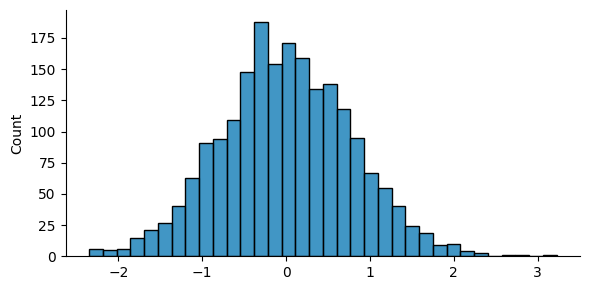

In [91]:
sns.displot(res.resid, height=3, aspect=2)

<Axes: ylabel='log_renda'>

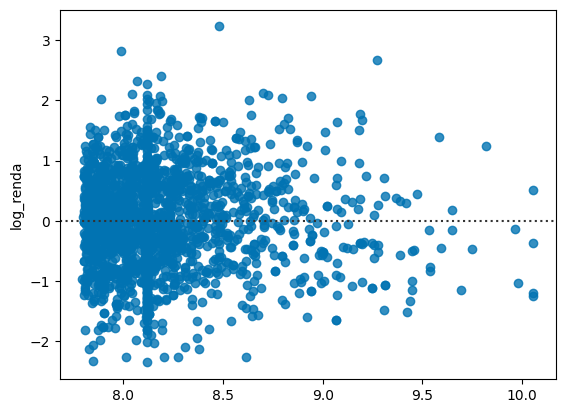

In [92]:
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

<Axes: ylabel='posse_de_imovel'>

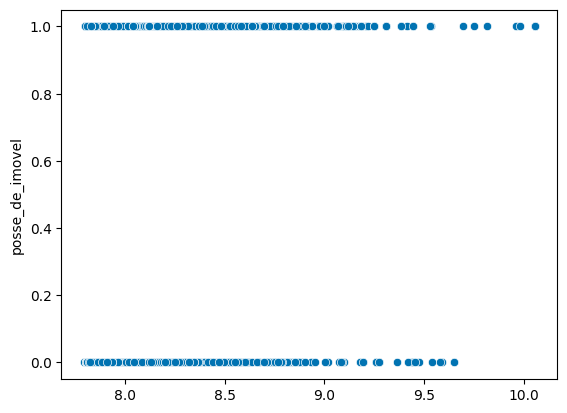

In [93]:
sns.scatterplot(x=res.predict(), y='posse_de_imovel', data=df_train)

<Axes: ylabel='tempo_emprego'>

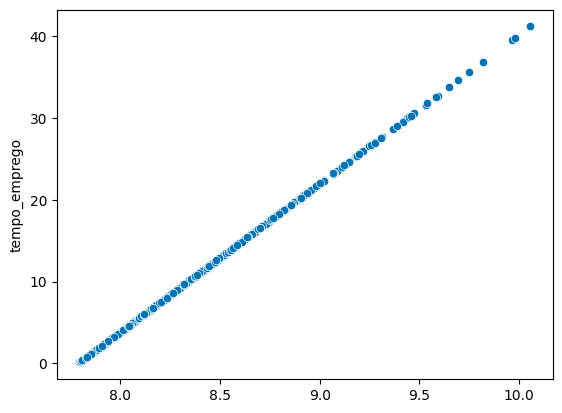

In [94]:
sns.scatterplot(x=res.predict(), y='tempo_emprego', data=df_train)

<Axes: ylabel='data_ref'>

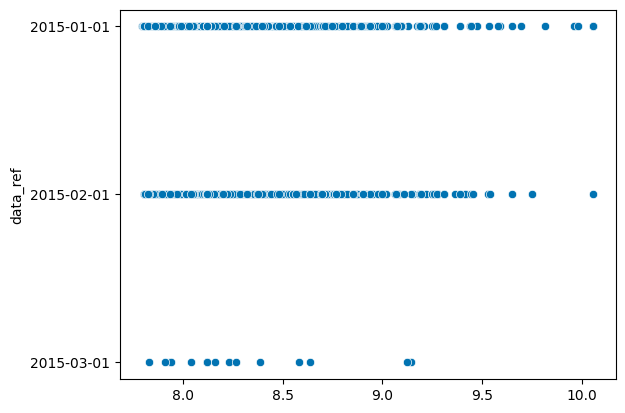

In [95]:
sns.scatterplot(x=res.predict(), y='data_ref', data=df_train)

<Axes: >

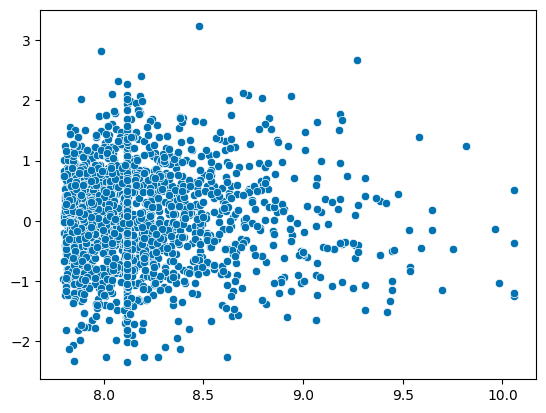

In [96]:
sns.scatterplot(x=res.predict(), y=res.resid)

---

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [97]:
# Converter a string para um objeto datetime
date = pd.to_datetime('2015-02-01')

# Indexar o DataFrame usando o objeto datetime
df_train_short = df_train.loc[:'2015-02-01'].copy()
df_train_short.reset_index(inplace=True)
df_train_short.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  2016 non-null   int64  
 1   Unnamed: 0             2016 non-null   int64  
 2   data_ref               2016 non-null   object 
 3   id_cliente             2016 non-null   int64  
 4   sexo                   2016 non-null   object 
 5   posse_de_veiculo       2016 non-null   bool   
 6   posse_de_imovel        2016 non-null   bool   
 7   qtd_filhos             2016 non-null   int64  
 8   tipo_renda             2016 non-null   object 
 9   educacao               2016 non-null   object 
 10  estado_civil           2016 non-null   object 
 11  tipo_residencia        2016 non-null   object 
 12  idade                  2016 non-null   int64  
 13  tempo_emprego          2016 non-null   float64
 14  qt_pessoas_residencia  2016 non-null   float64
 15  rend

In [98]:
reg = smf.ols('log_renda ~ tempo_emprego + posse_de_imovel', data=df_train_short).fit()

Text(0, 0.5, 'Resíduo')

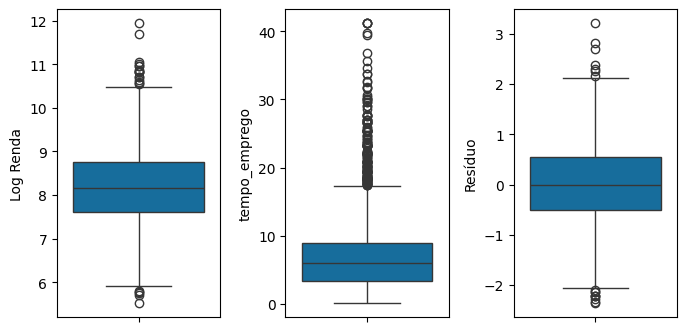

In [99]:
fix, ax = plt.subplots(1, 3, figsize=(8, 4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y='log_renda', data=df_train_short, ax=ax[0])
sns.boxplot(y='tempo_emprego', data=df_train_short, ax=ax[1])
sns.boxplot(y=reg.resid, data=df, ax=ax[2])

ax[0].set_ylabel('Log Renda')
ax[2].set_ylabel('Tempo Emprego')
ax[2].set_ylabel('Resíduo')

---

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [100]:
df_train_cut = df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']]
df_train_cut.head(2)

,posse_de_imovel,tempo_emprego,log_renda
0,True,6.602740,8.994711
1,True,7.183562,7.524102


In [101]:
# Correlação de *Spearman*

df_train_cut.corr(method='spearman')

,posse_de_imovel,tempo_emprego,log_renda
posse_de_imovel,1.000000,0.020282,0.021165
tempo_emprego,0.020282,1.000000,0.353117
log_renda,0.021165,0.353117,1.000000


In [102]:
# VIF

variaveis = ['tempo_emprego', 'posse_de_imovel']

df_train_cut_dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
df_train_cut_dum.head()

,tempo_emprego,posse_de_imovel
0,6.602740,True
1,7.183562,True
2,0.838356,True
3,4.846575,True
4,4.293151,False


---

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

### Sem edições necessárias